<a href="https://colab.research.google.com/github/AnyueWang/ExerciseProjects/blob/main/transfer_learning_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning - Feature Extraction

Transfer learning is a leveraging a working model's existing architecture and learned patterns for our own problem.

Benefits:
1. Leverage an existing neural network architecture proven to work on problems similar to our own.
2. Leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data.

In [1]:
!nvidia-smi

Sat Dec 24 10:20:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P0    26W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Downloading data

In [2]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

--2022-12-24 10:20:09--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.128, 142.251.10.128, 142.251.12.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  21.9MB/s    in 8.1s    

2022-12-24 10:20:17 (19.9 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
import os

for dirpath, dirnames, filenames in os.walk('10_food_classes_10_percent'):
  print(f'there are {len(dirnames)} directories and {len(filenames)} images in "{dirpath}".')

there are 2 directories and 0 images in "10_food_classes_10_percent".
there are 10 directories and 0 images in "10_food_classes_10_percent/test".
there are 0 directories and 250 images in "10_food_classes_10_percent/test/steak".
there are 0 directories and 250 images in "10_food_classes_10_percent/test/ice_cream".
there are 0 directories and 250 images in "10_food_classes_10_percent/test/hamburger".
there are 0 directories and 250 images in "10_food_classes_10_percent/test/chicken_wings".
there are 0 directories and 250 images in "10_food_classes_10_percent/test/chicken_curry".
there are 0 directories and 250 images in "10_food_classes_10_percent/test/pizza".
there are 0 directories and 250 images in "10_food_classes_10_percent/test/grilled_salmon".
there are 0 directories and 250 images in "10_food_classes_10_percent/test/ramen".
there are 0 directories and 250 images in "10_food_classes_10_percent/test/sushi".
there are 0 directories and 250 images in "10_food_classes_10_percent/test

## Create data loaders (preparing the data)


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print('training images:')
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                              target_size=IMAGE_SHAPE,
                              batch_size=BATCH_SIZE,
                              class_mode='categorical')

print('testing images:')
test_data = test_datagen.flow_from_directory(test_dir,
                        target_size=IMAGE_SHAPE,
                        batch_size=BATCH_SIZE,
                        class_mode='categorical')

training images:
Found 750 images belonging to 10 classes.
testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. 

* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback

In [5]:
# TensorBoard callback
import datetime
import tensorflow as tf

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime('%Y%M%D-%H%M%S')
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f'saving TensorBoard log files to: {log_dir}')
  return tensorboard_callback

## Creating models using TensorFlow Hub



In [6]:
resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'

efficientnet_url = 'https://tfhub.dev/google/efficientnet/b0/feature-vector/1'

In [7]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [8]:
def create_model(model_url, num_classes=10):
  '''
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (srt): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer, 
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor
    layer and Dense output layer with num_classes output neurons.
  '''
  feature_extractor_layer = hub.KerasLayer(model_url,
                        trainable=False, #freeze the already learned patterns
                        name='feature_extraction_layer',
                        input_shape=IMAGE_SHAPE+(3,)) 
  
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation='softmax', name='output_layer')
  ])

  return model


## Creating and testing ResNet TensorFlow Hub Feature Extraction model

In [9]:
resnet_model = create_model(resnet_url,
               num_classes=train_data_10_percent.num_classes)

In [10]:
resnet_model.compile(loss='categorical_crossentropy',
           optimizer=tf.keras.optimizers.Adam(),
           metrics='accuracy')

In [11]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [12]:
from tensorflow.python.ops.variables import validate_synchronization_aggregation_trainable
resnet_history = resnet_model.fit(train_data_10_percent,
               epochs=5,
               steps_per_epoch=len(train_data_10_percent),
               validation_data=test_data,
               validation_steps=len(test_data),
               callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                   experiment_name='resnet50V2')])

saving TensorBoard log files to: tensorflow_hub/resnet50V2/20222012/24/22-102036
Epoch 1/5
24/24 [==============================] - 34s 844ms/step - loss: 1.9085 - accuracy: 0.3693 - val_loss: 1.1660 - val_accuracy: 0.6384
Epoch 2/5
24/24 [==============================] - 17s 708ms/step - loss: 0.9050 - accuracy: 0.7307 - val_loss: 0.8375 - val_accuracy: 0.7328
Epoch 3/5
24/24 [==============================] - 24s 1s/step - loss: 0.6070 - accuracy: 0.8333 - val_loss: 0.7452 - val_accuracy: 0.7636
Epoch 4/5
24/24 [==============================] - 16s 670ms/step - loss: 0.4723 - accuracy: 0.8813 - val_loss: 0.6913 - val_accuracy: 0.7804
Epoch 5/5
24/24 [==============================] - 16s 676ms/step - loss: 0.3710 - accuracy: 0.9280 - val_loss: 0.6664 - val_accuracy: 0.7856


In [13]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  df = pd.DataFrame(history.history)

  df[['loss','val_loss']].plot()
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')

  plt.figure()
  df[['accuracy','val_accuracy']].plot()
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')

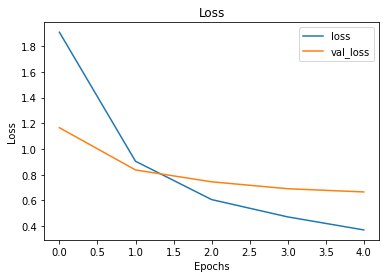

<Figure size 432x288 with 0 Axes>

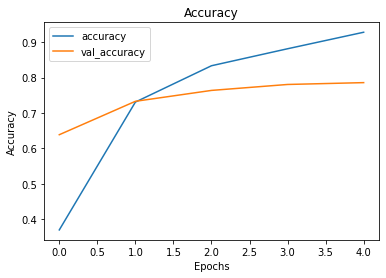

In [14]:
plot_loss_curves(resnet_history)

## Creating and testing EfficientNet TensorFlow Hub Feature Extraction model

In [15]:
efficientnet_model = create_model(model_url=efficientnet_url,
                  num_classes=train_data_10_percent.num_classes)

In [16]:
efficientnet_model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [17]:
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                        epochs=5,
                        validation_data=test_data,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_steps=len(test_data),
                        callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                            experiment_name='effcientnetb0')])

saving TensorBoard log files to: tensorflow_hub/effcientnetb0/20222212/24/22-102229
Epoch 1/5
24/24 [==============================] - 20s 697ms/step - loss: 1.8738 - accuracy: 0.4067 - val_loss: 1.3188 - val_accuracy: 0.7264
Epoch 2/5
24/24 [==============================] - 15s 640ms/step - loss: 1.0821 - accuracy: 0.7653 - val_loss: 0.8687 - val_accuracy: 0.8236
Epoch 3/5
24/24 [==============================] - 16s 679ms/step - loss: 0.7564 - accuracy: 0.8320 - val_loss: 0.6941 - val_accuracy: 0.8448
Epoch 4/5
24/24 [==============================] - 15s 638ms/step - loss: 0.6082 - accuracy: 0.8693 - val_loss: 0.6098 - val_accuracy: 0.8508
Epoch 5/5
24/24 [==============================] - 15s 634ms/step - loss: 0.5136 - accuracy: 0.8867 - val_loss: 0.5525 - val_accuracy: 0.8636


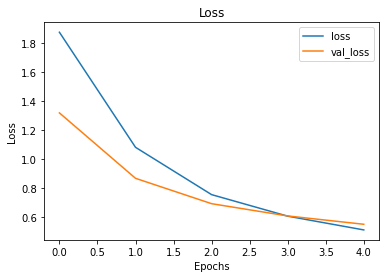

<Figure size 432x288 with 0 Axes>

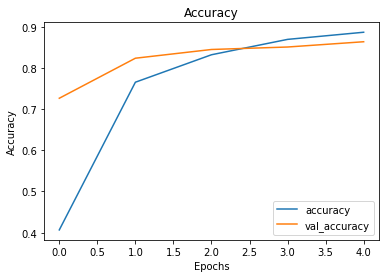

In [18]:
plot_loss_curves(efficientnet_history)

## Different types of transfer learning

* Transfer learning with no changes
* Feature extraction
* Fine-tuning transfer learning

In [22]:
len(efficientnet_model.layers[0].weights)

309

## Comparing model results using TensorBoard

In [24]:
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name 'EfficientNet vs. ResNet' \
  --description 'Comparing two different TF Hub feature extraction model architecture' \
  --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=6ZnFe8PxLjskQC4dmg7arG7vpe6e9g&prompt=consent&access_type=off

In [25]:
!tensorboard dev list

https://tensorboard.dev/experiment/eUpE8WvNROuomkTlipwRJw/
	Name                 EfficientNet vs. ResNet
	Description          Comparing two different TF Hub feature extraction model architecture
	Id                   eUpE8WvNROuomkTlipwRJw
	Created              2022-12-24 10:38:02 (4 minutes ago)
	Updated              2022-12-24 10:38:07 (4 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  3140503
Total: 1 experiment(s)


In [26]:
#!tensorboard dev delete --experiment_id eUpE8WvNROuomkTlipwRJw